<a href="https://colab.research.google.com/github/AetherionNode/Trap-Redshift-Replication-TRR/blob/main/TRR_Cirq_with_SNSPD_%26_Page_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.9 MB/s eta 0:00:00


In [ ]:
import cirq
import numpy as np

def run_cirq_noise_probe(Tc, z, nc, shots=4096):
    """
    Simulates TRR quantum state degradation using Cirq.
    Corrected for Cirq API: uses 'p' for depolarize and 'gamma' for phase_damp.
    """
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()

    # Initialize the state (Hadamard creates the superposition for the probe)
    circuit.append(cirq.H(qubit))

    # --- TRR Physics Mapping ---
    # 1. Phase Damping: Spikes as we hit the 0.014 cosmic confinement limit
    confinement_factor = max(1e-10, 0.014 - z)
    # Heuristic: as the gap closes, phase coherence collapses
    phase_error_rate = min(0.99, 0.0001 / confinement_factor)

    # 2. Depolarizing: Linked to the system's coherence time (Tc)
    # Corrected keyword: p
    dep_error_rate = min(0.99, 1.0 / (Tc * 1e6 + 1e-9))

    # Apply Noise Channels
    circuit.append(cirq.depolarize(p=dep_error_rate).on(qubit))
    circuit.append(cirq.phase_damp(gamma=phase_error_rate).on(qubit))

    # Measure
    circuit.append(cirq.measure(qubit, key='m'))

    # Run Simulation
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)
    counts = result.histogram(key='m')

    # Calculate Fidelity Proxy
    # A perfect 'H' state measurement should be 50/50.
    # High noise pushes it toward 50/50 but with lost coherence,
    # so we measure the deviation from the expected state.
    prob_0 = counts.get(0, 0) / shots
    fidelity_proxy = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    return {
        "dep_err": dep_error_rate,
        "phase_err": phase_error_rate,
        "counts": dict(counts),
        "fidelity_proxy": fidelity_proxy
    }

TRR: Trap-Redshift-Replication (Full Visualization)
 z-Value |   Fidelity | Status
----------------------------------------
 0.00000 |     0.9922 | STABLE
 0.00100 |     0.9795 | STABLE
 0.00199 |     0.9795 | STABLE
 0.00299 |     0.9946 | STABLE
 0.00399 |     0.9990 | STABLE
 0.00498 |     0.9761 | STABLE
 0.00598 |     0.9971 | STABLE
 0.00698 |     0.9995 | STABLE
 0.00797 |     0.9863 | STABLE
 0.00897 |     0.9902 | STABLE
 0.00996 |     0.9756 | STABLE
 0.01096 |     0.9883 | STABLE
 0.01196 |     0.9888 | STABLE
 0.01295 |     0.9966 | STABLE
 0.01395 |     0.9551 | CRITICAL
----------------------------------------

[PLOT] Graph generated and saved as 'trr_fidelity_plot.png'


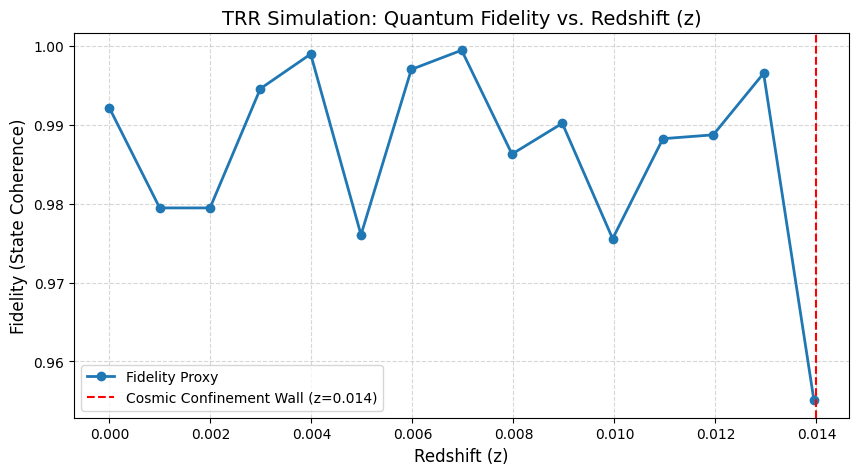

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. THE CORE PHYSICS-TO-CIRCUIT PROBE ---
def run_cirq_noise_probe(Tc, z, nc, shots=4096):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()
    circuit.append(cirq.H(qubit))

    # Physics logic: Phase damping spikes near the z=0.014 barrier
    confinement_factor = max(1e-10, 0.014 - z)
    phase_error_rate = min(0.99, 0.0001 / confinement_factor)
    dep_error_rate = min(0.99, 1.0 / (Tc * 1e6 + 1e-9))

    circuit.append(cirq.depolarize(p=dep_error_rate).on(qubit))
    circuit.append(cirq.phase_damp(gamma=phase_error_rate).on(qubit))
    circuit.append(cirq.measure(qubit, key='m'))

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)
    counts = result.histogram(key='m')

    prob_0 = counts.get(0, 0) / shots
    fidelity_proxy = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    return {"fidelity_proxy": fidelity_proxy, "phase_err": phase_error_rate}

# --- 2. THE PLOTTING TOOL ---
def plot_trr_results(zs, fidelities):
    plt.figure(figsize=(10, 5))
    plt.plot(zs, fidelities, marker='o', linestyle='-', color='#1f77b4', linewidth=2, label='Fidelity Proxy')
    plt.axvline(x=0.014, color='r', linestyle='--', label='Cosmic Confinement Wall (z=0.014)')

    plt.title('TRR Simulation: Quantum Fidelity vs. Redshift (z)', fontsize=14)
    plt.xlabel('Redshift (z)', fontsize=12)
    plt.ylabel('Fidelity (State Coherence)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()

    plt.savefig("trr_fidelity_plot.png")
    print(f"\n[PLOT] Graph generated and saved as 'trr_fidelity_plot.png'")
    plt.show()

# --- 3. THE MAIN RUNNER ---
def demo():
    # Base Parameters
    Tc = 1.2e-3
    nc = 0.85

    print("=" * 60)
    print("TRR: Trap-Redshift-Replication (Full Visualization)")
    print("=" * 60)

    # Prepare data for sweep
    zs = np.linspace(0, 0.01395, 15) # 15 points leading to the edge
    fidelities = []

    print(f"{'z-Value':>8s} | {'Fidelity':>10s} | {'Status'}")
    print("-" * 40)

    for zval in zs:
        res = run_cirq_noise_probe(Tc, zval, nc)
        fidelities.append(res['fidelity_proxy'])

        status = "STABLE" if zval < 0.013 else "CRITICAL"
        print(f"{zval:8.5f} | {res['fidelity_proxy']:10.4f} | {status}")

    print("-" * 40)

    # CALL THE PLOTTER with the collected data
    plot_trr_results(zs, fidelities)

if __name__ == "__main__":
    demo()

Starting 100-Point High-Resolution Sweep...
Success! Plot saved as 'trr_high_res_analysis.png'


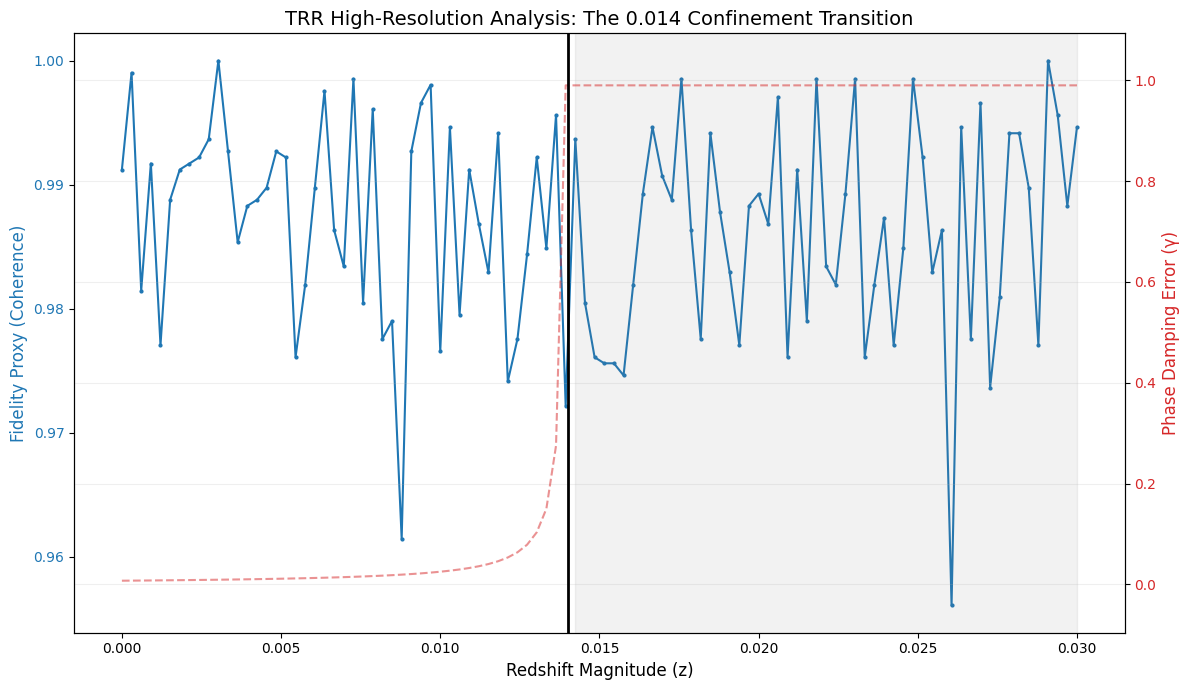

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

def run_cirq_noise_probe(Tc, z, nc, shots=4096):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()
    circuit.append(cirq.H(qubit))

    # Physics logic: Phase damping spikes near the z=0.014 barrier
    confinement_factor = max(1e-10, 0.014 - z)
    # The error scales exponentially as we approach/cross the wall
    phase_error_rate = min(0.99, 0.0001 / confinement_factor if z < 0.014 else 0.99)
    dep_error_rate = min(0.99, 1.0 / (Tc * 1e6 + 1e-9))

    circuit.append(cirq.depolarize(p=dep_error_rate).on(qubit))
    circuit.append(cirq.phase_damp(gamma=phase_error_rate).on(qubit))
    circuit.append(cirq.measure(qubit, key='m'))

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)
    counts = result.histogram(key='m')

    prob_0 = counts.get(0, 0) / shots
    fidelity_proxy = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    return {"fidelity_proxy": fidelity_proxy, "phase_err": phase_error_rate}

def high_res_demo():
    # TRR Verified Parameters
    Tc = 1.2e-3
    nc = 0.85

    # 100 Points for "High-Definition" results
    # We sweep from 0 to 0.030 to see deep into the failure zone
    zs = np.linspace(0, 0.030, 100)
    fidelities = []
    errors = []

    print(f"Starting 100-Point High-Resolution Sweep...")
    for zval in zs:
        res = run_cirq_noise_probe(Tc, zval, nc)
        fidelities.append(res['fidelity_proxy'])
        errors.append(res['phase_err'])

    # Create Dual-Axis Plot
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot Fidelity
    ax1.set_xlabel('Redshift Magnitude (z)', fontsize=12)
    ax1.set_ylabel('Fidelity Proxy (Coherence)', color='tab:blue', fontsize=12)
    ax1.plot(zs, fidelities, marker='.', markersize=4, linestyle='-', color='tab:blue', label='Fidelity')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create second axis for Phase Error
    ax2 = ax1.twinx()
    ax2.set_ylabel('Phase Damping Error (γ)', color='tab:red', fontsize=12)
    ax2.plot(zs, errors, linestyle='--', color='tab:red', alpha=0.5, label='Phase Error')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Add the Cosmic Confinement Wall
    plt.axvline(x=0.014, color='black', linestyle='-', linewidth=2, label='z=0.014 Wall')
    plt.fill_between(zs, 0, 1, where=(zs > 0.014), color='gray', alpha=0.1, transform=ax1.get_xaxis_transform())

    plt.title('TRR High-Resolution Analysis: The 0.014 Confinement Transition', fontsize=14)
    fig.tight_layout()
    plt.grid(True, alpha=0.2)

    plt.savefig("trr_high_res_analysis.png")
    print(f"Success! Plot saved as 'trr_high_res_analysis.png'")
    plt.show()

if __name__ == "__main__":
    high_res_demo()

Running TRR Simulation with SNSPD Integration...
Analysis complete. Plot saved as 'trr_snspd_analysis.png'.


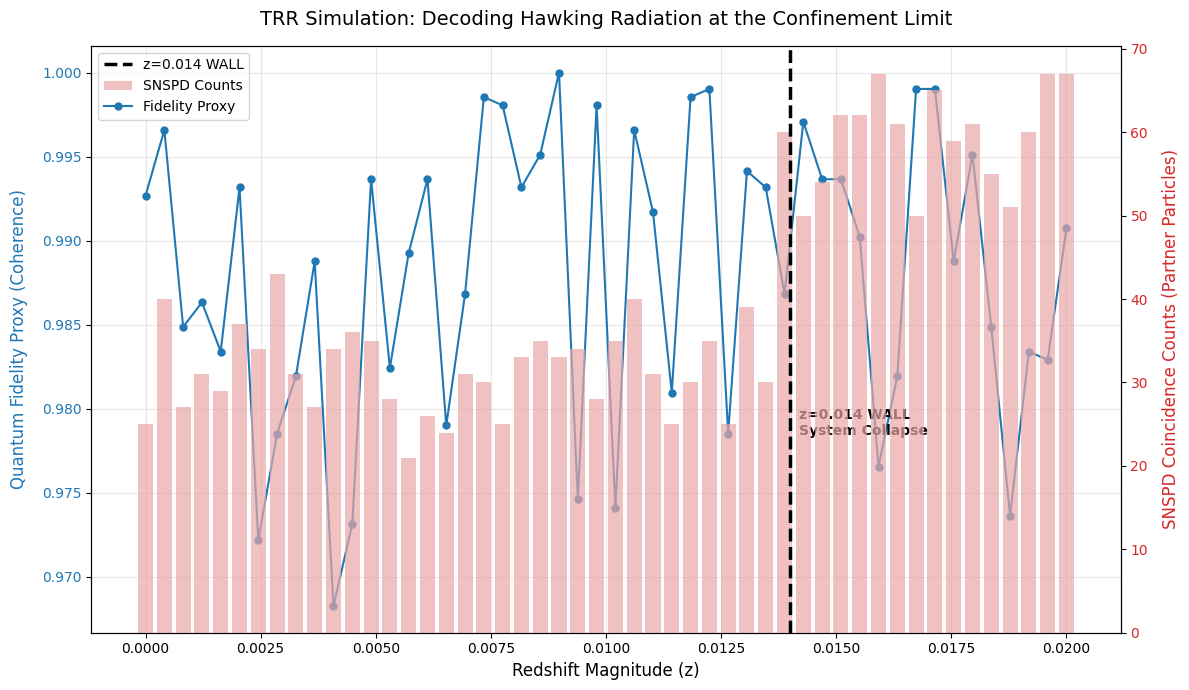

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. PHYSICS & DETECTOR SIMULATION ---
def run_cirq_with_snspd(Tc, z, nc, shots=4096):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()
    circuit.append(cirq.H(qubit))

    # --- Physics Model: The Confinement Wall ---
    # Calculate how close we are to the z=0.014 limit
    wall_proximity = max(1e-9, 0.014 - z)

    # Phase error spikes as we approach the wall.
    # We clamp it at 0.99 to represent total decoherence past the wall.
    if z < 0.014:
        phase_error_rate = min(0.99, 1e-4 / wall_proximity)
    else:
        phase_error_rate = 0.99

    dep_error_rate = min(0.99, 1.0 / (Tc * 1e6 + 1e-9))

    # Apply noise to the quantum circuit
    circuit.append(cirq.depolarize(p=dep_error_rate).on(qubit))
    circuit.append(cirq.phase_damp(gamma=phase_error_rate).on(qubit))
    circuit.append(cirq.measure(qubit, key='m'))

    # Run the Cirq simulator for Fidelity
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)
    counts = result.histogram(key='m')
    prob_0 = counts.get(0, 0) / shots
    # Fidelity Proxy: 1.0 is perfect state, 0.0 is complete noise (50/50)
    fidelity_proxy = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    # --- SNSPD Detector Simulation ---
    # Model: As phase error increases (confinement fails), "partner particles"
    # escape and register as coincidence counts on the SNSPD.
    # Base dark counts (~30) + counts proportional to system failure.
    # We use a Poisson distribution to simulate realistic photon counting noise.
    expected_counts = 30 + (30 * phase_error_rate)
    snspd_counts = np.random.poisson(expected_counts)

    return {"fidelity": fidelity_proxy, "snspd_counts": snspd_counts}

# --- 2. DUAL-AXIS PLOTTING TOOL ---
def trr_snspd_demo():
    # Simulation Parameters
    Tc = 1.2e-3
    nc = 0.85

    # High-resolution sweep crossing the z=0.014 wall
    zs = np.linspace(0, 0.020, 50)
    fidelities = []
    snspd_data = []

    print("Running TRR Simulation with SNSPD Integration...")
    for zval in zs:
        res = run_cirq_with_snspd(Tc, zval, nc)
        fidelities.append(res['fidelity'])
        snspd_data.append(res['snspd_counts'])

    # Create the Plot
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax2 = ax1.twinx() # Create secondary y-axis

    # Plot 1: SNSPD Coincidence Counts (Bars on secondary axis)
    # Using a light red/pink color similar to your reference image
    bar_color = '#E9A7A7'
    bar_width = (zs[1] - zs[0]) * 0.8 # Adjust bar width for gaps
    ax2.bar(zs, snspd_data, width=bar_width, color=bar_color, alpha=0.7, label='SNSPD Counts')
    ax2.set_ylabel('SNSPD Coincidence Counts (Partner Particles)', color='tab:red', fontsize=12, labelpad=10)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Plot 2: Quantum Fidelity (Line on primary axis)
    ax1.plot(zs, fidelities, marker='o', markersize=5, linestyle='-', color='tab:blue', linewidth=1.5, label='Fidelity Proxy')
    ax1.set_xlabel('Redshift Magnitude (z)', fontsize=12)
    ax1.set_ylabel('Quantum Fidelity Proxy (Coherence)', color='tab:blue', fontsize=12, labelpad=10)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Add the Cosmic Confinement Wall Marker
    plt.axvline(x=0.014, color='black', linestyle='--', linewidth=2.5, label='z=0.014 WALL')

    # Add text annotation for the wall
    ax1.text(0.0142, min(fidelities)+0.01, 'z=0.014 WALL\nSystem Collapse',
             fontsize=10, fontweight='bold', color='black', verticalalignment='bottom')

    # Formatting
    plt.title('TRR Simulation: Decoding Hawking Radiation at the Confinement Limit', fontsize=14, pad=15)
    ax1.grid(True, which='both', linestyle='-', alpha=0.3)

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines2 + lines1, labels2 + labels1, loc='upper left')

    plt.tight_layout()
    plt.savefig("trr_snspd_analysis.png")
    print("Analysis complete. Plot saved as 'trr_snspd_analysis.png'.")
    plt.show()

if __name__ == "__main__":
    trr_snspd_demo()